In [1]:
from pathlib import Path

import torch
import matplotlib.pyplot as plt
from numpy import pi, inf, exp, mean, max
from torch import sin
from torch.autograd import grad

In [2]:
figpath = Path("../figures/norm-estimates")
figpath.mkdir(exist_ok=True)

In [3]:
def torch_nth_derivative(f, x, n):
    """Compute n-th order derivative of a function f: R -> R at the 
    points x in R.
    """
    if x.requires_grad:
        detach = False
    else:
        detach = True
        x.requires_grad = True
    
    g = f(x).sum()
    dx = f(x)

    for i in range(n):
        dx = grad(g, x, create_graph=True)[0]
        g = dx.sum()
        
    if detach:
        x.requires_grad = False
        return dx.detach()
    
    return dx

class SineVectorField:
    """Vector field class defined as a weigthed sum of fourier sine basis functions,
    f(x) = w_j sin(j π x)"""
    def __init__(self, weights):
        self.d = weights.numel()
        self.N = torch.arange(1, self.d+1, dtype=torch.float32)
        self.weights = weights.float()
        
    def __call__(self, x):
        return (self.weights * torch.sin(pi * self.N * x) / (pi * self.N)).sum(dim=-1, keepdims=True)

    
class ComposedVectorfield:
    """ Vector field defined as a composition of "euler-step diffeomorphism",
    
    F(x) = ( (x + f_1(x)) o (x + f_2(x)) o ... o (x + f_L(x)) ) - x
    """
    def __init__(self, vector_field_collection):
        self.collection = vector_field_collection
        
    def __call__(self, x):
        y = x
        for fl in self.collection:
            y = y + fl(y)
        return y - x
    
    def get_weight_matrix(self):
        return torch.stack([fi.weights for fi in self.collection])

def approx_max_norm(f, k, npoints=int(1e4)):
    """ C^k-norm estimate of 1-dimensional vector fields."""
    xx = torch.linspace(0, 1, npoints).view(-1, 1)
    df = torch_nth_derivative(f, xx, n=k)
    return torch.abs(df).max()

def one_hot(i, N):
    """ Create a vector with a single 1 entry, otherwise 0."""
    vec = torch.zeros(N)
    vec[i] = 1.
    return vec

def scale_weights_loose_common(W, k):
    """ Scale weight matrix """
    L, d = W.shape
    N = torch.arange(1, d+1) 
    
    scalar = (torch.abs(W) * (N * pi)**(k-1)).sum()
    if scalar >= 1 - 1e-8:
        W *= (1-1e-8) / scalar
        
    return W

def scale_weights_loose_separate(W, k):
    L, d = W.shape
    N = torch.arange(1, d+1)
    
    for wi in W:
        scalar = (torch.abs(wi) * (N * pi)**(k-1)).sum()
        if scalar >= (1.0 - 1e-7)/ L:
            wi *= (1.0 - 1e-8) / (L * scalar)
    return W

def scale_weights_tight_common(W, k):
    L, d = W.shape
    N = torch.arange(1, d+1)
    
    # Create vector field collection
    F = ComposedVectorfield([SineVectorField(wi) for wi in W])
    
    # Compute the sum of the C^k-norms for the different vector fields
    scalar = torch.stack([approx_max_norm(fi, k=k) for fi in F.collection])
    scalar = float(scalar.sum())
    if scalar >= 1 - 1e-8:
        W *= (1-1e-8) / scalar
    
    return W

def scale_weights_tight_separate(W, k):
    L, d = W.shape
    N = torch.arange(1, d+1)
    for wi in W:
        scalar = approx_max_norm(SineVectorField(wi), k=k)
        if scalar >= 1. / L - 1e-8:
            wi *= (1./L - 1e-8) / scalar
    return W


def norm_sum_estimate(vector_field_collection, k):
    out = torch.stack([approx_max_norm(fi, k=k) for fi in vector_field_collection])
    return float(out.sum())

def project(W, k, norm_estimate, scale_strategy):
    projection_methods = {
        ("loose", "common"): scale_weights_loose_common,
        ("loose", "separate"): scale_weights_loose_separate,
        ("tight", "common"): scale_weights_tight_common,
        ("tight", "separate"): scale_weights_tight_separate
    }
    return projection_methods[(norm_estimate, scale_strategy)](W, k)

def norm_estimate(W, k, projection_norm_estimate, projection_scale_strategy):
    W = project(W, k, projection_norm_estimate, projection_scale_strategy)
    
    F = ComposedVectorfield([SineVectorField(torch.clone(wi)) for wi in W])
    field_sum = norm_sum_estimate(F.collection, k)
    return approx_max_norm(F, k) / (exp(k) * field_sum)
    

def deterministic_norm_estimate(L, d, k, projection_norm_estimate, projection_scale_strategy):
    W = torch.ones(L, d)
    return norm_estimate(W, k, projection_norm_estimate, projection_scale_strategy)


def random_norm_estimate(L, d, k, projection_norm_estimate, projection_scale_strategy, runs):
    return max([norm_estimate(torch.randn(L, d), k, projection_norm_estimate, projection_scale_strategy) 
                 for _ in range(runs)])

In [4]:
def save_fig(fig, label, k, norm_estimate, projection_strat):
    fig.savefig(
        figpath / f"{label}-{norm_estimate}-{projection_strat}-k_{k}.pdf", bbox_inches="tight"
    )


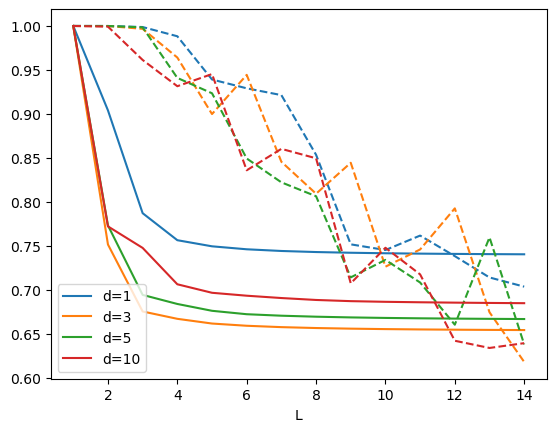

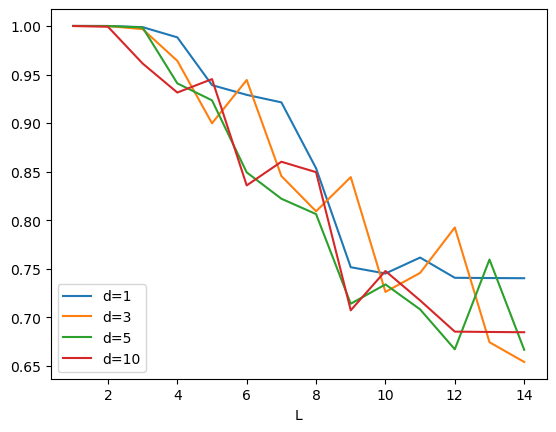

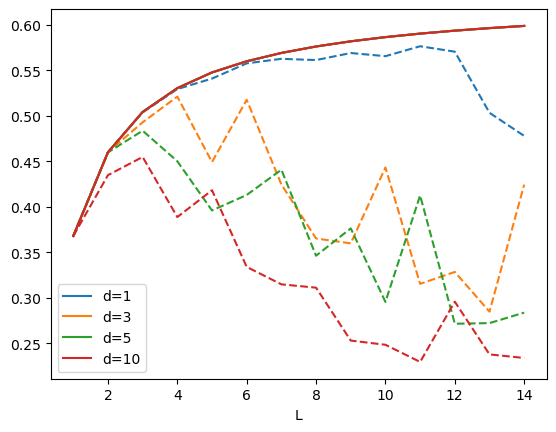

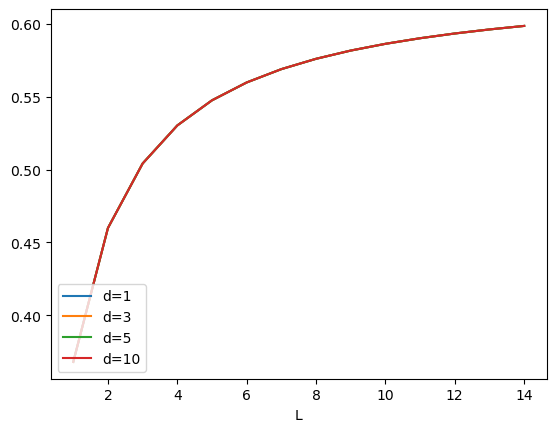

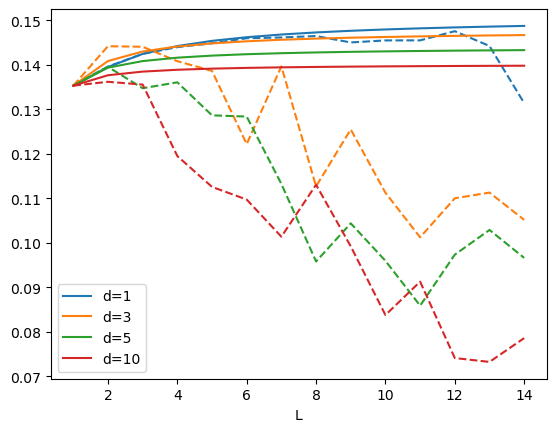

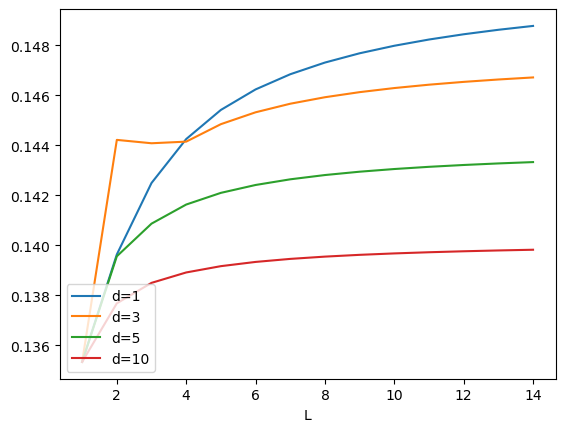

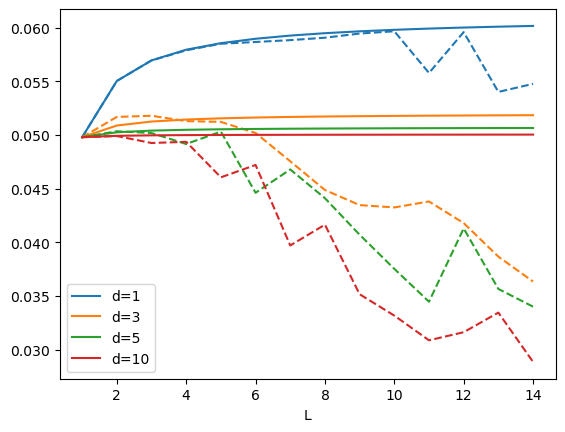

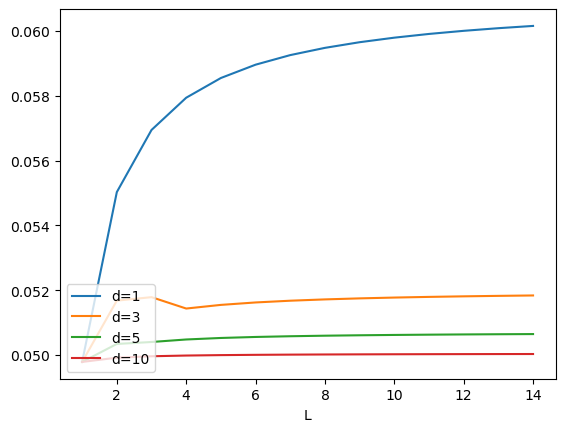

In [5]:
RUNS=600
norm_est = "loose"
projection_strat = "separate"
for k in range(1, 4):
    fig1, ax1, = plt.subplots()
    fig2, ax2, = plt.subplots()
    for d in [1, 3, 5, 10]:
        L = range(1, 15)
        deterministic = [deterministic_norm_estimate(l, d, k, norm_est, projection_strat) for l in L]
        random = [random_norm_estimate(l, d, k, norm_est, projection_strat, RUNS) for l in L]
        line, = ax1.plot(L, deterministic, label=f"d={d}")
        ax1.plot(L, random, "--", color=line.get_color())
        ax2.plot(L, [max(ti) for ti in zip(random, deterministic)], label=f"d={d}")

    ax1.legend(loc="lower left")
#     ax1.set_ylim(0, None)
    ax1.set_xlabel("L")
    ax2.legend(loc="lower left")
#     ax2.set_ylim(0, None)
    ax2.set_xlabel("L")
    save_fig(fig1, "layers-both", k, norm_est, projection_strat)
    save_fig(fig2, "layers-max", k, norm_est, projection_strat)
    plt.show()

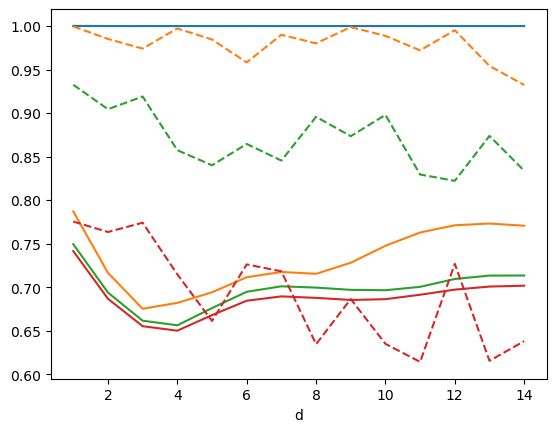

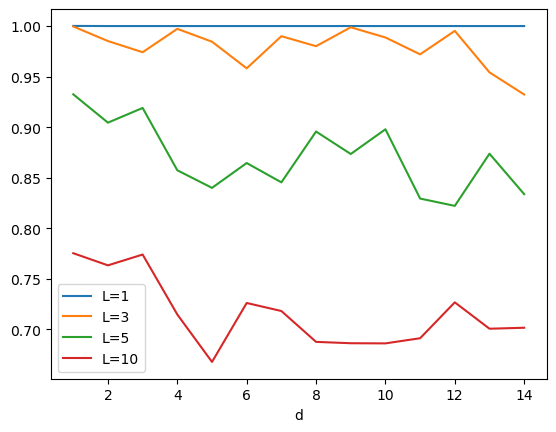

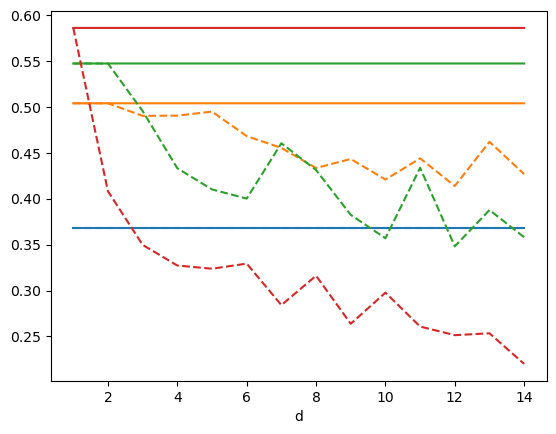

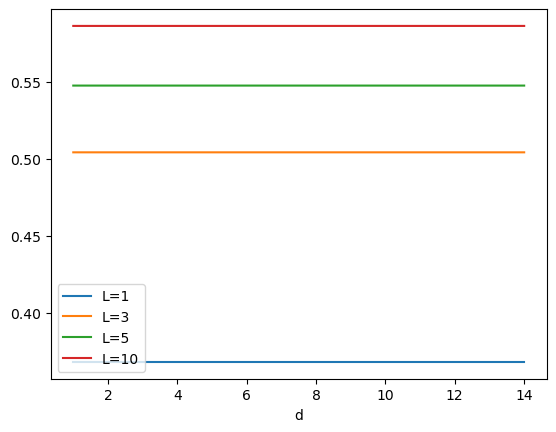

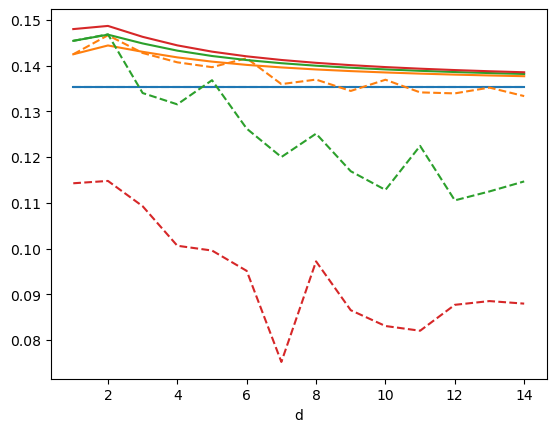

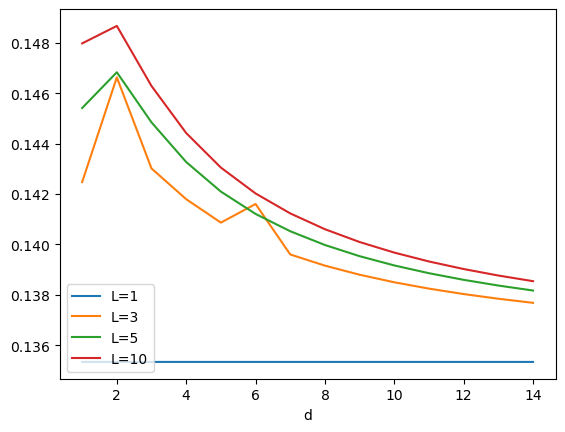

In [ ]:
for k in range(1, 4):
    fig1, ax1, = plt.subplots()
    fig2, ax2, = plt.subplots()
    for L in [1, 3, 5, 10]:
        D = range(1, 15)
        deterministic = [deterministic_norm_estimate(L, d, k, "loose", "separate") for d in D]
        random = [random_norm_estimate(L, d, k, "loose", "separate", RUNS) for d in D]
        line, = ax1.plot(D, deterministic, label=f"L={L}")
        ax1.plot(D, random, "--", color=line.get_color())
        ax2.plot(D, [max(ti) for ti in zip(random, deterministic)], label=f"L={L}")


    ax2.legend(loc="lower left")
#     ax1.set_ylim(0, None)
    ax1.set_xlabel("d")
    ax2.legend(loc="lower left")
#     ax2.set_ylim(0, None)
    ax2.set_xlabel("d")
    fig1.savefig(figpath / f"norm-estimates-width-both-k_{k}-d_{d}.pdf", bbox_inches="tight")
    fig2.savefig(figpath / f"norm-estimates-width-max-k_{k}-d_{d}.pdf", bbox_inches="tight")
    plt.show()